In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from utils import *

### Loading in the data with the desired features

Data (along with labels) can be found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/GDF6Z0

In [2]:
cols = ['gender', 'birthyr', 'educ', 'race', 'countyfips', 'pew_religimp', 'newsint', 'CC16_351I', 'CC16_302', 'CC16_331_7', 'CC16_330d', 'CC16_332a', 'CC16_351K', 'CC16_335', 'CC16_364c']
df = pd.read_csv('data/CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t', header=0, usecols=cols)[cols]
df = clean(df)

In [3]:
df.head()

,gender,age,educ,race,state,pew_religimp,newsint,CC16_351I,CC16_302,CC16_331_7,CC16_330d,CC16_332a,CC16_351K,CC16_335,CC16_364c
0,2,47,2,1,33,2,2,1,3,1,2,1,1,1,1
2,2,52,2,2,29,1,2,1,5,2,1,2,1,1,2
4,2,34,5,1,08,4,1,2,2,2,1,2,1,1,2
5,2,53,2,6,01,1,3,1,4,1,1,1,1,1,2
6,1,54,2,1,48,1,1,1,3,1,2,2,1,2,1


### Verifying that there are no "skipped" responses, crosschecked to the data source pdf

In [4]:
features = df.columns.tolist()
features.remove('age')
features.remove('state')
for feature in features:
    print(f'{feature} : {df[feature].unique()}')

gender : [2 1]
educ : [2 5 3 6 4 1]
race : [1 2 6 4 3 5 7 8]
pew_religimp : [2 1 4 3]
newsint : [2 1 3 7 4]
CC16_351I : [1 2]
CC16_302 : [3 5 2 4 6 1]
CC16_331_7 : [1 2]
CC16_330d : [2 1]
CC16_332a : [1 2]
CC16_351K : [1 2]
CC16_335 : [1 2]
CC16_364c : [1 2]


### Verifying that there are no highly correlated features

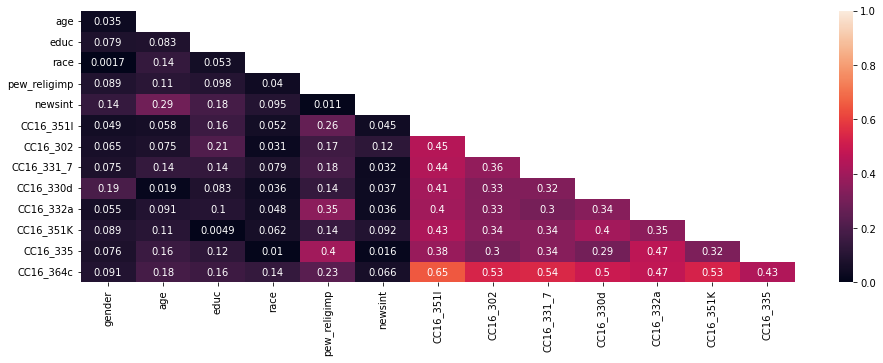

In [5]:
corr_heatmap(df)

### Splitting the data evenly by party

In [6]:
def sampling_k_elements(group, k=min(df.CC16_364c.value_counts())):
    if len(group) < k:
        return group
    return group.sample(k)

df = df.groupby('CC16_364c').apply(sampling_k_elements).reset_index(drop=True)

In [7]:
train, test = train_test_split(df, stratify=df.CC16_364c, test_size=0.3, random_state=42)
data_train, data_eval, label_train, label_eval = train_test_split(train.drop('CC16_364c', axis=1), train.CC16_364c, stratify=train.CC16_364c, test_size=0.3, random_state=42)
data_test, label_test = test.drop('CC16_364c', axis=1), test.CC16_364c

In [8]:
label_train.value_counts(), label_eval.value_counts(), label_test.value_counts()

(2    9194
 1    9193
 Name: CC16_364c, dtype: int64,
 1    3941
 2    3940
 Name: CC16_364c, dtype: int64,
 1    5629
 2    5629
 Name: CC16_364c, dtype: int64)

### Making/Training the model

In [9]:
categorical_features_indices = np.where(train.dtypes != int)[0]

In [11]:
classifier = CatBoostClassifier(iterations=1000, depth=3, learning_rate=0.05, loss_function='Logloss', eval_metric='Accuracy')
classifier.fit(data_train, label_train, cat_features=categorical_features_indices, eval_set=(data_eval, label_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8581063	test: 0.8599163	best: 0.8599163 (0)	total: 18.7ms	remaining: 18.6s
1:	learn: 0.8697993	test: 0.8736201	best: 0.8736201 (1)	total: 40.5ms	remaining: 20.2s
2:	learn: 0.8664274	test: 0.8698135	best: 0.8736201 (1)	total: 57.8ms	remaining: 19.2s
3:	learn: 0.8571817	test: 0.8605507	best: 0.8736201 (1)	total: 73.7ms	remaining: 18.4s
4:	learn: 0.8684940	test: 0.8713361	best: 0.8736201 (1)	total: 89.6ms	remaining: 17.8s
5:	learn: 0.8688204	test: 0.8728588	best: 0.8736201 (1)	total: 106ms	remaining: 17.5s
6:	learn: 0.8593572	test: 0.8615658	best: 0.8736201 (1)	total: 125ms	remaining: 17.7s
7:	learn: 0.8699081	test: 0.8734932	best: 0.8736201 (1)	total: 145ms	remaining: 18s
8:	learn: 0.8721379	test: 0.8734932	best: 0.8736201 (1)	total: 166ms	remaining: 18.3s
9:	learn: 0.8750748	test: 0.8767923	best: 0.8767923 (9)	total: 190ms	remaining: 18.8s
10:	learn: 0.8758906	test: 0.8769192	best: 0.8769192 (10)	total: 212ms	remaining: 19s
11:	learn: 0.8775765	test: 0.8795838	best: 0.879583

### Model Performance

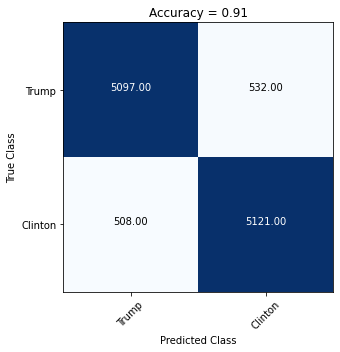

In [12]:
preds = classifier.predict(data_test)
cm = confusion_matrix(label_test, preds, labels=[1, 2])
plot_confusion_matrix(cm, ['Trump', 'Clinton'], f'Accuracy = {np.round(classifier.score(data_test, label_test), 2)}')

In [ ]:
classifier.save_model("catboost_classifier")